# **ETA Prediction with Machine Learning**

## **Introduction**

Ride-hailing apps like Uber and Yassir rely on real-time data and machine learning algorithms to automate their services. Accurately predicting the estimated time of arrival (ETA) for Yassir trips will make Yassir’s services more reliable and attractive; this will have a direct and indirect impact on both customers and business partners. The solution would help the company save money and allocate more resources to other parts of the business.

The objective of this hackathon is to predict the estimated time of arrival at the dropoff point for a single Yassir journey.

This project will use the [CRISP-DM](https://www.datascience-pm.com/crisp-dm-2/) framework for data science problems

(Dataset : [Yassir Data](https://zindi.africa/competitions/yassir-eta-prediction-challenge-for-azubian/data))

## **1. Business Understanding**

*Predicting Estimated Time of Arrival (ETA) for Yassir Journeys*

Ride-hailing platforms such as Uber and Yassir operate in a fast-paced environment, relying on real-time data and advanced machine learning algorithms to enhance their services. In particular, accurate prediction of the Estimated Time of Arrival (ETA) for Yassir trips is crucial for improving the reliability and attractiveness of the service to both customers and business partners.

ETAs are used to calculate ride fares, estimate pickup times, match riders to drivers, plan deliveries, and much more. The estimated time of arrival should be as accurate as possible. If estimate is higher then user might cancel the order or if it is lower user might complain and uninstall the app. In both cases there is loss for the company, thus making this a key metric for their business model.

For several years, [Uber used gradient-boosted decision tree ensembles](https://www.uber.com/en-KE/blog/deepeta-how-uber-predicts-arrival-times/) to refine their ETA predictions. As their training dataset grew, Uber’s Apache Spark™ team contributed upstream improvements to XGBoost to allow the model to grow ever deeper, making it one of the largest and deepest XGBoost ensembles in the world at that time. They have since moved to a deep learning due to the ease of scaling on large datasets.

The ETA will vary due to factors such as trip distance and/or weather-related issues.

### Objectives
The  goal is to develop a predictive model capable of accurately estimating the time it takes for a Yassir journey to reach its drop-off point. By achieving this objective, Yassir aims to enhance the overall efficiency and quality of its service, providing tangible benefits to both customers and business partners.

## **2. Data Understanding**

##### **ID:** A unique identifier associated with each record in the dataset.

##### **Timestamp:** The date and time when the trip was started.

##### **Origin_lat and Origin_lon:** The geographical coordinates (latitude and longitude) of the starting point of each trip.

##### **Destination_lat and Destination_lon:** The geographical coordinates (latitude and longitude) of the destination point of each trip.

##### **Trip_distance:** The distance of the trip in in meters on a driving route.

##### **ETA (Estimated Time of Arrival):** Estimated trip time in seconds.

| ID | Timestamp | Origin_lat | Origin_lon | Destination_lat | Destination_lon | Trip_distance | ETA |
|----|-----------|------------|------------|------------------|------------------|---------------|-----|
|Unique| Date| latitude | longitude | destinatination lat | destination long | Trip distance | ETA |

### Importation
Here is the section to import all the packages/libraries that will be used through this notebook.

In [1]:
import os, joblib

# Data handling
import pandas as pd
import numpy as np

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#EDA
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


### Data Loading
Here is the section to load the datasets (train, eval, test) and the additional files

In [2]:
# load training data
training = pd.read_csv(r'Dataset\Train.csv').set_index('ID')
training['Timestamp'] = pd.to_datetime(training['Timestamp'])
training.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
ID,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138


In [3]:
# testing data
testing = pd.read_csv(r'Dataset\Test.csv').set_index('ID')
testing['Timestamp'] = pd.to_datetime(testing['Timestamp'])
testing.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
ID,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513


In [4]:
# weather data
weather_df = pd.read_csv(r'Dataset\Weather.csv')
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


### Exploratory Data Analysis: EDA
Here is the section to **inspect** the datasets in depth, **present** it, make **hypotheses** and **think** the *cleaning, processing and features creation*.

In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83924 entries, 000FLWA8 to ZZZY11ZN
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp        83924 non-null  datetime64[ns, UTC]
 1   Origin_lat       83924 non-null  float64            
 2   Origin_lon       83924 non-null  float64            
 3   Destination_lat  83924 non-null  float64            
 4   Destination_lon  83924 non-null  float64            
 5   Trip_distance    83924 non-null  int64              
 6   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 5.1+ MB


In [6]:
#let's check if we are missing values
training.isna().sum()

Timestamp          0
Origin_lat         0
Origin_lon         0
Destination_lat    0
Destination_lon    0
Trip_distance      0
ETA                0
dtype: int64

- no missing values

In [7]:
# format numerical columns to 2 decimal places with comma separator
pd.options.display.float_format = '{:,.2f}'.format

# statistics for numerical columns
training.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,"83,924.00","83,924.00","83,924.00","83,924.00","83,924.00","83,924.00"
mean,3.05,36.74,3.06,36.74,"13,527.82","1,111.70"
std,0.10,0.03,0.10,0.03,"9,296.72",563.57
min,2.81,36.59,2.81,36.60,1.00,1.00
25%,2.99,36.72,3.00,36.72,"6,108.00",701.00
50%,3.05,36.74,3.05,36.74,"11,731.50","1,054.00"
75%,3.10,36.76,3.11,36.76,"19,369.00","1,456.00"
max,3.38,36.82,3.38,36.82,"62,028.00","5,238.00"


- **Timestamp**: The data spans various dates in 2019.
- **Origin and Destination Coordinates (Latitude and Longitude)**: The average coordinates are approximately 3.05 latitude and 36.74 longitude for both origin and destination. The minimum and maximum values show a limited range.
- **Trip Distance**: The average trip distance is approximately 13,527.82 M, with a minimum of 1.00 M and a maximum of 62,028.00 M. Some anomalies with low distance.
- **ETA (Estimated Time of Arrival)**: The average ETA is approximately 1,111.70s, with a minimum of 1.00s and a maximum of 5,238.00s. There could be some anomalies here with low ETA's.

#### Univariate Analysis

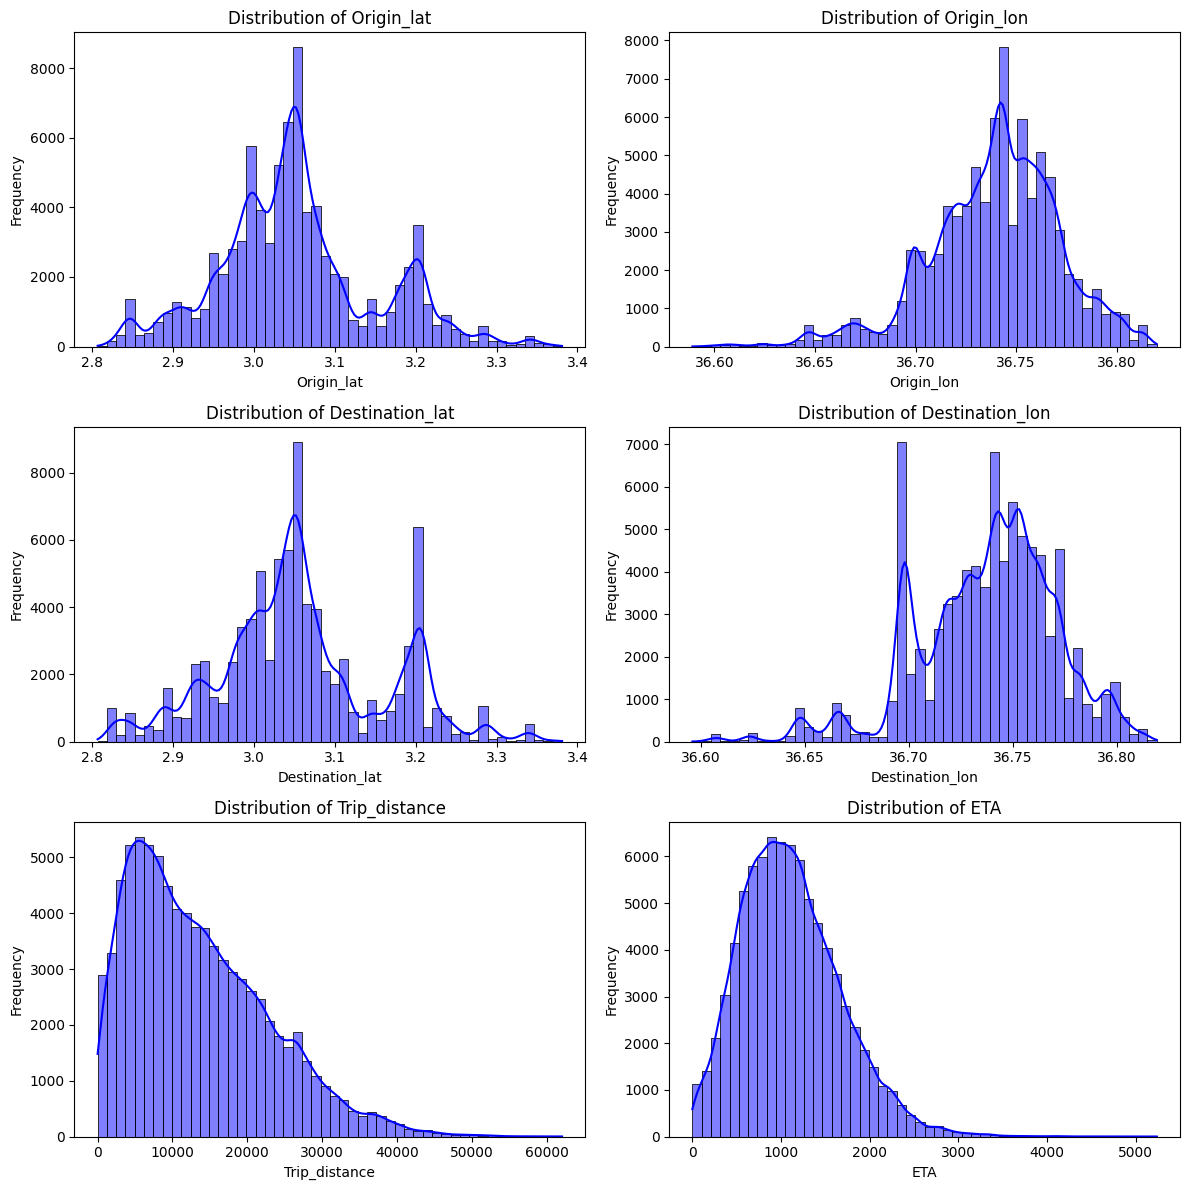

In [8]:
# Create histograms with KDE plots to visualize distribution
cols = ['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon', 'Trip_distance', 'ETA']

# Calculate the number of rows needed
num_rows = len(cols) // 2 + len(cols) % 2

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Iterate over columns and create histograms with KDE plots
for i, column in enumerate(cols):
    sns.histplot(training[column], kde=True, bins=50, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if the number of subplots is odd
if len(cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

- The origin and destination points seem to be in the same coordinates, indicating that the majority of the trips are likely within a single geographic area. This concentration of data in a specific zone is likely associated with internal activity within a country, potentially representing a dense urban area or a hub of economic activity.

- Trip distance and ETA are positively skewed. This suggest the direction of outliers towards the upper bound of the dataset.

#### Bivariate Analysis

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_37008\4218137300.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


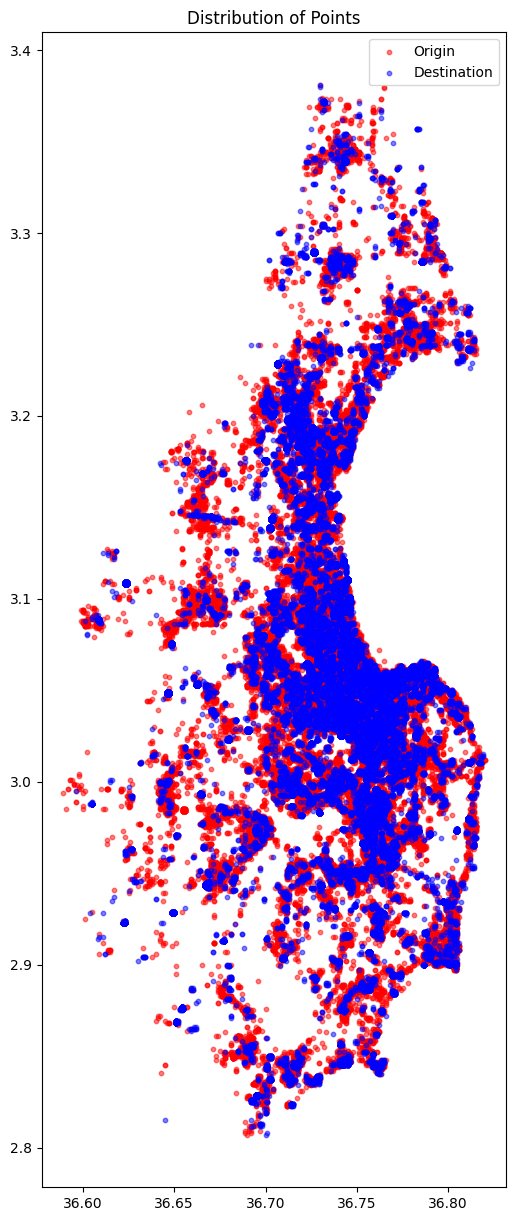

In [9]:
# Create a GeoDataFrame based on the origin coordinates
geometry_origin = [Point(lon, lat) for lon, lat in zip(training['Origin_lon'], training['Origin_lat'])]
gdf_origin = gpd.GeoDataFrame(training, geometry=geometry_origin, crs='EPSG:4326')

# Create a GeoDataFrame based on the destination coordinates
geometry_destination = [Point(lon, lat) for lon, lat in zip(training['Destination_lon'], training['Destination_lat'])]
gdf_destination = gpd.GeoDataFrame(training, geometry=geometry_destination, crs='EPSG:4326')

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Display the world map
fig, ax = plt.subplots(figsize=(15, 15))

# Uncomment the line below if you want to plot world boundaries
# world.boundary.plot(ax=ax, linewidth=1)
ax.set_title('Distribution of Points')

# Overlay the origin and destination points
gdf_origin.plot(ax=ax, color='red', markersize=10, alpha=0.5, label='Origin')
gdf_destination.plot(ax=ax, color='blue', markersize=10, alpha=0.5, label='Destination')

# Add a legend
plt.legend()

plt.show()

- the visualization of the map indeed confirms the concentration of data within a specific geographic area. The proximity of the origin and destination points, along with the clustering observed on the map, aligns with the interpretation of strong local activity.

In [10]:
# Use the geopy locator with Nominatim/OpenStreetMaps
locator = Nominatim(user_agent='myGeoencoder')
coordinates = ['3.258,36.777'] #check the location data for one point
location = locator.reverse(coordinates)
location.raw

{'place_id': 36498003,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 198507881,
 'lat': '3.2580337654742446',
 'lon': '36.78034168388619',
 'class': 'highway',
 'type': 'unclassified',
 'place_rank': 26,
 'importance': 0.10000999999999993,
 'addresstype': 'road',
 'name': '',
 'display_name': 'North Horr, Marsabit, Eastern, Kenya',
 'address': {'village': 'North Horr',
  'county': 'North Horr',
  'state': 'Marsabit',
  'ISO3166-2-lvl4': 'KE-25',
  'country': 'Kenya',
  'country_code': 'ke'},
 'boundingbox': ['3.1638051', '3.3438366', '36.7788893', '36.7984563']}

- Our datapoints are somewhere in Marsabit state, Kenya
- We can extract location data such as county and state with reverse geocoding

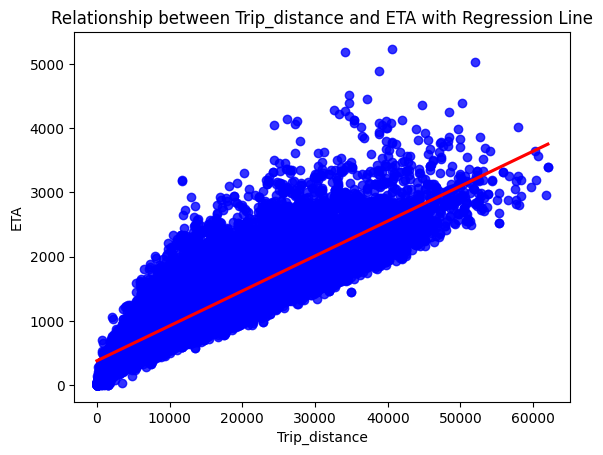

In [11]:
# check regression line
# Scatter plot with regression line
sns.regplot(x='Trip_distance', y='ETA', data=gdf_origin, scatter_kws={'color':'blue'}, line_kws={'color':'red'})

# Set x-axis label
plt.xlabel('Trip_distance')

# Set y-axis label
plt.ylabel('ETA')

# Set plot title
plt.title('Relationship between Trip_distance and ETA with Regression Line')

# Show the plot
plt.show()

The analysis of the relationship between the trip distance ('Trip_distance') and the estimated time of arrival ('ETA') indicates a significant correlation, suggesting a linear trend where longer trip distances are associated with longer arrival times. However, the presence of points deviating from the regression line suggests some variability and the possibility of atypical observations.

#### Multivariate Analysis

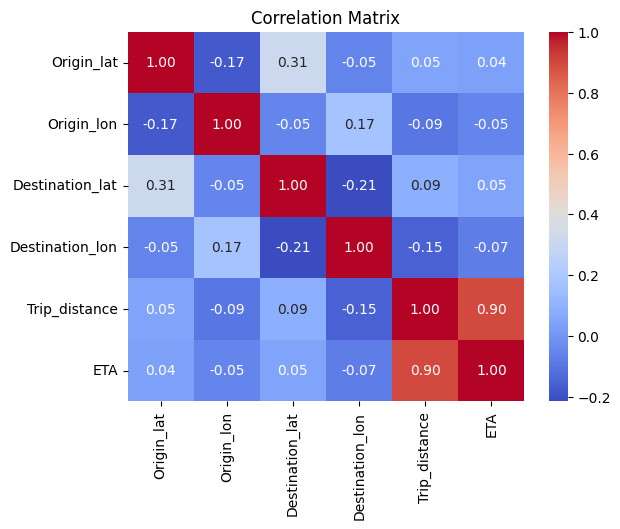

In [12]:
# Create a correlation matrix for continuous variables
train = training.drop('Timestamp', axis=1)
correlation_matrix = train.corr()

# Display the correlation matrix with a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Add a title
plt.title('Correlation Matrix')

# Display the plot
plt.show()

- ETA and trip distance have a strong positive correlation as expected. longer trips typically require more time to be covered.
- There is also a positive relationship between origin/destination latitude and origin/destination longitude

## 3. Data Preparation

### Feature Processing & Engineering
Here is the section to **clean**, **process** the dataset and **create new features**.

In [13]:
training.reset_index(inplace=True)
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83924 entries, 0 to 83923
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   ID               83924 non-null  object             
 1   Timestamp        83924 non-null  datetime64[ns, UTC]
 2   Origin_lat       83924 non-null  float64            
 3   Origin_lon       83924 non-null  float64            
 4   Destination_lat  83924 non-null  float64            
 5   Destination_lon  83924 non-null  float64            
 6   Trip_distance    83924 non-null  int64              
 7   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(1)
memory usage: 5.1+ MB


In [14]:
# drop 'ID' column
training.drop(['ID'],axis=1, inplace = True)

#### Add speed feature

In [15]:
# Add 'speed' feature
training['Speed'] = training['Trip_distance'] / training['ETA'] * 3.6
training.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed
0,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784,51.24
1,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49
2,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72
3,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130,26.86
4,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65


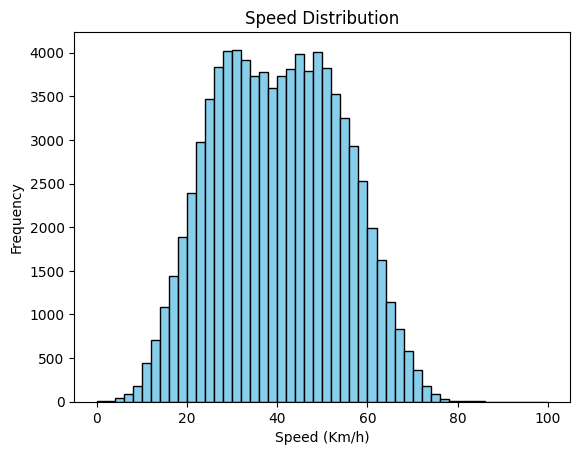

In [16]:
# Histogram of the speed column with x-axis limit
plt.hist(training['Speed'], bins=50, color='skyblue', edgecolor='black', range=[0, 100])
plt.title('Speed Distribution')
plt.xlabel('Speed (Km/h)')
plt.ylabel('Frequency')
plt.show()

We observe a concentration of speed between 20 and 60, indicating that most observations have speeds within this range. This suggests that the majority of trips in our dataset occur at relatively low-average speeds.

#### Merge training data and weather data

In [17]:
# Merge 'Weather' and 'training' on date column

training['date']=training['Timestamp'].dt.date
training['date']=pd.to_datetime(training['date'])
training_merged=pd.merge(training,weather_df, how='left', on='date')
print(training_merged.shape)
training_merged.head()

(83924, 18)


,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784,51.24,2019-12-04,283.05,288.32,286.98,"100,523.06",286.00,"99,474.22",0.01,1.91,2.44
1,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49,2019-12-10,282.29,289.17,286.99,"102,472.15",283.80,"101,401.24",0.00,2.55,-1.54
2,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72,2019-11-23,284.37,292.54,289.94,"100,172.91",287.65,"99,133.38",0.01,6.64,3.55
3,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130,26.86,2019-12-01,284.53,292.35,288.69,"101,382.91",285.94,"100,338.46",0.00,-0.08,1.09
4,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65,2019-12-17,281.46,292.58,291.20,"100,634.46",287.55,"99,595.82",0.00,-1.77,2.67


#### Extract date-time features

In [18]:
def add_date_features(df,timestamp_id):

    df.loc[:, 'pickup_weekday'] = df[timestamp_id].dt.weekday
    df.loc[:, 'pickup_weekofyear'] = df[timestamp_id].dt.isocalendar().week
    df.loc[:, 'pickup_hour'] = df[timestamp_id].dt.hour
    df.loc[:, 'pickup_minute'] = df[timestamp_id].dt.minute
    df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    df['month']=df[timestamp_id].dt.month
    df['day_of_week']=df[timestamp_id].dt.dayofweek
    df['day_of_year']=df[timestamp_id].dt.dayofyear

In [19]:
add_date_features(training_merged,'Timestamp')

In [20]:
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,u_component_of_wind_10m,v_component_of_wind_10m,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year
0,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784,51.24,2019-12-04,283.05,...,1.91,2.44,2,49,20,1,68,12,2,338
1,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49,2019-12-10,282.29,...,2.55,-1.54,1,50,22,37,46,12,1,344
2,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72,2019-11-23,284.37,...,6.64,3.55,5,47,20,36,140,11,5,327
3,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130,26.86,2019-12-01,284.53,...,-0.08,1.09,6,48,5,43,149,12,6,335
4,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65,2019-12-17,281.46,...,-1.77,2.67,1,51,20,30,44,12,1,351


#### Handle Outliers

- Outliers have a big effect on rmse score

ETA


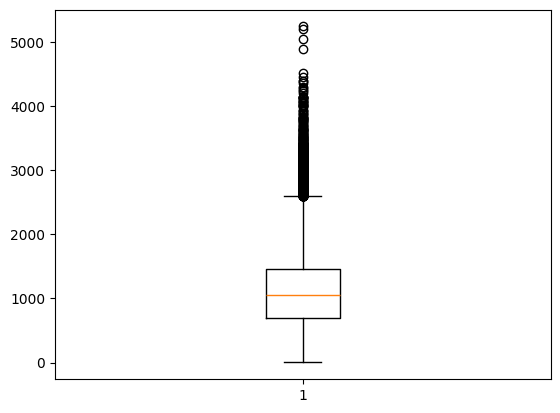

Trip_distance


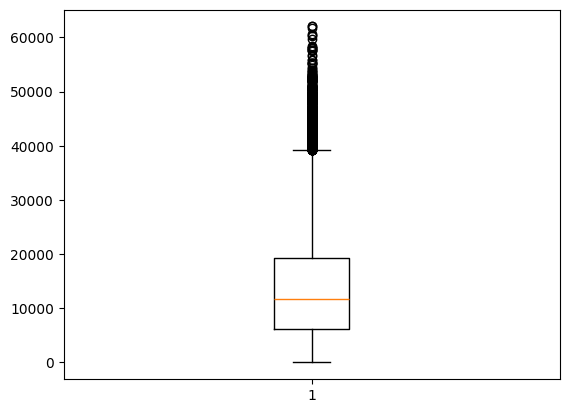

Speed


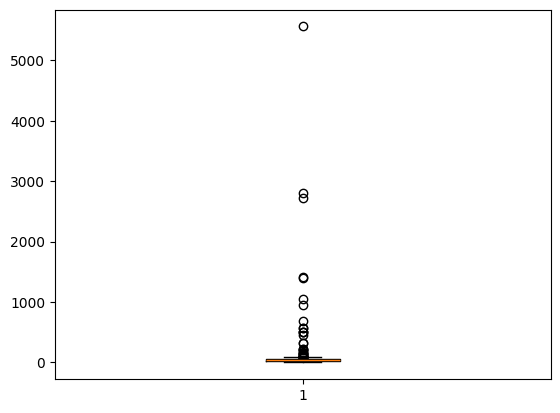

In [21]:
# Check for outliers in the numerical variables
# Use boxplot

for col in ['ETA','Trip_distance','Speed']:
    print(col)
    plt.boxplot(training_merged[col])
    plt.show()

In [22]:
#Function to detect and remove outliers
def remove_outliers(data, columns, threshold=1.5):
    """
    Remove outliers from numerical columns using the Interquartile Range (IQR) method.

    Parameters:
    - data: DataFrame, the input DataFrame.
    - columns: list, the list of numerical columns for which outliers should be removed.
    - threshold: float, the threshold to determine outliers (default is 1.5).

    Returns:
    - DataFrame, the DataFrame without outliers in the specified columns.
    """

    data_no_outliers = training_merged.copy()

    for column in columns:
        # Calculate the IQR for the column
        q1 = data_no_outliers[column].quantile(0.25)
        q3 = data_no_outliers[column].quantile(0.75)
        iqr = q3 - q1

        # Define the lower and upper bounds for outliers
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr

        # Remove outliers
        data_no_outliers = data_no_outliers[(data_no_outliers[column] >= lower_bound) & (data_no_outliers[column] <= upper_bound)]

    return data_no_outliers

In [23]:
numeric_columns = ['ETA', 'Speed', 'Trip_distance']
training_merged = remove_outliers(training_merged, numeric_columns)
training_merged = training_merged.reset_index(drop=True)

In [24]:
training_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82213 entries, 0 to 82212
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   Timestamp                   82213 non-null  datetime64[ns, UTC]
 1   Origin_lat                  82213 non-null  float64            
 2   Origin_lon                  82213 non-null  float64            
 3   Destination_lat             82213 non-null  float64            
 4   Destination_lon             82213 non-null  float64            
 5   Trip_distance               82213 non-null  int64              
 6   ETA                         82213 non-null  int64              
 7   Speed                       82213 non-null  float64            
 8   date                        82213 non-null  datetime64[ns]     
 9   dewpoint_2m_temperature     82213 non-null  float64            
 10  maximum_2m_air_temperature  82213 non-null  float64       

#### handle missing values

In [25]:
#check missing values
training_merged.isna().sum()

Timestamp                     0
Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
ETA                           0
Speed                         0
date                          0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
pickup_weekday                0
pickup_weekofyear             0
pickup_hour                   0
pickup_minute                 0
pickup_week_hour              0
month                         0
day_of_week                   0
day_of_year                   0
dtype: int64

#### handle duplicate values

In [26]:
#check for duplicates
training_merged.duplicated().sum()

157

In [27]:
training_merged = training_merged.set_index('Timestamp')
training_merged.sort_index(ascending=True, inplace=True)

In [28]:
# show all occurences of duplicated rows
training_merged[training_merged.duplicated(keep=False)]

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,maximum_2m_air_temperature,...,u_component_of_wind_10m,v_component_of_wind_10m,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:04:03+00:00,3.01,36.78,3.21,36.70,24652,1589,55.85,2019-11-19,281.22,288.50,...,3.20,0.88,1,47,23,4,47,11,1,323
2019-11-19 23:04:12+00:00,3.01,36.78,3.21,36.70,24652,1589,55.85,2019-11-19,281.22,288.50,...,3.20,0.88,1,47,23,4,47,11,1,323
2019-11-19 23:38:14+00:00,2.90,36.80,2.89,36.75,6670,795,30.20,2019-11-19,281.22,288.50,...,3.20,0.88,1,47,23,38,47,11,1,323
2019-11-19 23:38:14+00:00,2.90,36.80,2.89,36.75,6670,795,30.20,2019-11-19,281.22,288.50,...,3.20,0.88,1,47,23,38,47,11,1,323
2019-11-19 23:46:58+00:00,2.85,36.68,3.05,36.78,26065,1678,55.92,2019-11-19,281.22,288.50,...,3.20,0.88,1,47,23,46,47,11,1,323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19 23:19:36+00:00,2.97,36.76,3.19,36.73,30512,1683,65.27,2019-12-19,281.00,290.57,...,1.82,2.30,3,51,23,19,95,12,3,353
2019-12-19 23:19:43+00:00,2.97,36.76,3.19,36.73,30512,1683,65.27,2019-12-19,281.00,290.57,...,1.82,2.30,3,51,23,19,95,12,3,353
2019-12-19 23:19:46+00:00,2.97,36.76,3.19,36.73,30512,1683,65.27,2019-12-19,281.00,290.57,...,1.82,2.30,3,51,23,19,95,12,3,353


In [29]:
# Drop duplicates
training_merged.drop_duplicates(inplace = True)

In [30]:
training_merged = training_merged.reset_index()
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,u_component_of_wind_10m,v_component_of_wind_10m,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year
0,2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,3898,556,25.24,2019-11-19,281.22,...,3.20,0.88,1,47,23,0,47,11,1,323
1,2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,5861,785,26.88,2019-11-19,281.22,...,3.20,0.88,1,47,23,0,47,11,1,323
2,2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,26065,1661,56.49,2019-11-19,281.22,...,3.20,0.88,1,47,23,0,47,11,1,323
3,2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,4943,629,28.29,2019-11-19,281.22,...,3.20,0.88,1,47,23,0,47,11,1,323
4,2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,37492,2181,61.89,2019-11-19,281.22,...,3.20,0.88,1,47,23,0,47,11,1,323


#### Clustering coordinates

c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

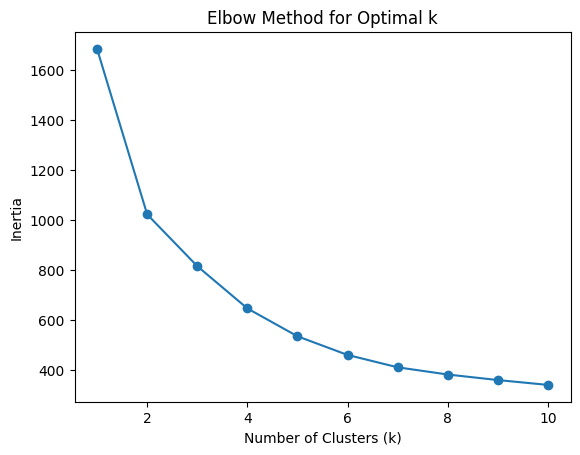

In [31]:
# Elbow method to find best k clusters

coords = training_merged[['Origin_lat'	,'Origin_lon'	,'Destination_lat'	,'Destination_lon']]

# Assuming data is your feature matrix
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

- Graph shows elbow at K=2, however it is not clear enough. In this case we will use our max=10

In [32]:
#trip clustering
kmean=KMeans(n_clusters=10,random_state= 0)

training_merged["cluster_id"]=kmean.fit_predict(coords)

c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [33]:
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,v_component_of_wind_10m,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id
0,2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,3898,556,25.24,2019-11-19,281.22,...,0.88,1,47,23,0,47,11,1,323,5
1,2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,5861,785,26.88,2019-11-19,281.22,...,0.88,1,47,23,0,47,11,1,323,4
2,2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,26065,1661,56.49,2019-11-19,281.22,...,0.88,1,47,23,0,47,11,1,323,0
3,2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,4943,629,28.29,2019-11-19,281.22,...,0.88,1,47,23,0,47,11,1,323,4
4,2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,37492,2181,61.89,2019-11-19,281.22,...,0.88,1,47,23,0,47,11,1,323,0


#### Transform target variable

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_37008\3181792633.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target)


skewness :  0.33990314044708436


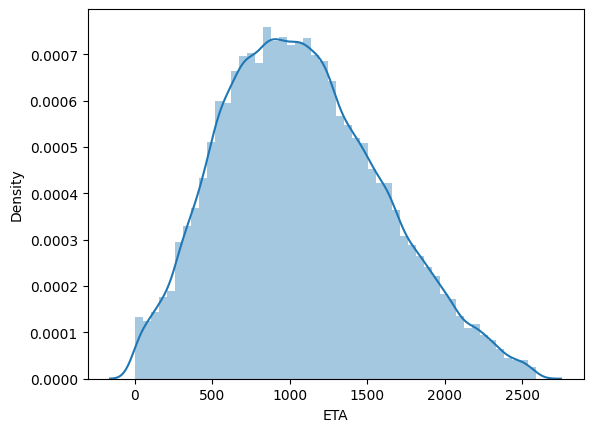

In [34]:
target = training_merged["ETA"]
sns.distplot(target)
print("skewness : ",stats.skew(target.values))

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_37008\1576812632.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_transformed)


Skewness after Box-Cox transformation: [-0.06791846]


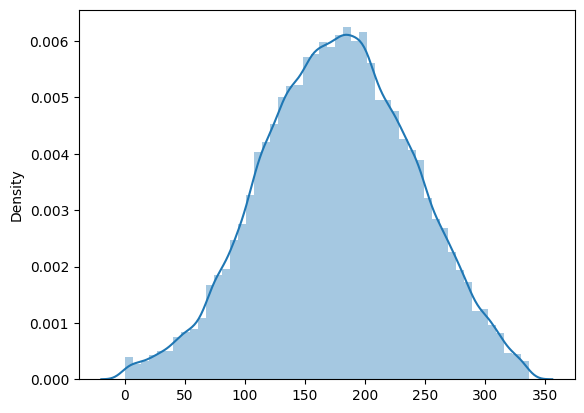

In [35]:
# Reshape the target variable with PowerTransformer
target = target.values.reshape(-1, 1)

# Create and fit the PowerTransformer with boxcox method
boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)
target_transformed = boxcox_transformer.fit_transform(target)

# Plot the distribution of the transformed target variable
sns.distplot(target_transformed)
print("Skewness after Box-Cox transformation:", stats.skew(target_transformed))

In [36]:
training_merged['target_transformed'] = target_transformed
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed
0,2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,3898,556,25.24,2019-11-19,281.22,...,1,47,23,0,47,11,1,323,5,114.67
1,2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,5861,785,26.88,2019-11-19,281.22,...,1,47,23,0,47,11,1,323,4,146.10
2,2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,26065,1661,56.49,2019-11-19,281.22,...,1,47,23,0,47,11,1,323,0,246.86
3,2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,4943,629,28.29,2019-11-19,281.22,...,1,47,23,0,47,11,1,323,4,125.06
4,2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,37492,2181,61.89,2019-11-19,281.22,...,1,47,23,0,47,11,1,323,0,298.57


In [37]:
#drop columns
training_merged = training_merged.drop(columns= ['date', 'surface_pressure']
              ,axis=1)

In [38]:
# Add weather features

# temperature_range
training_merged['temperature_range'] = training_merged['maximum_2m_air_temperature'] - training_merged['minimum_2m_air_temperature']

# Calculate wind speed
training_merged['wind_speed'] = np.sqrt(training_merged['u_component_of_wind_10m']**2 + training_merged['v_component_of_wind_10m']**2)

# Rain
training_merged['rain'] = (training_merged['total_precipitation'] > 0).astype(int)

In [39]:
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,dewpoint_2m_temperature,maximum_2m_air_temperature,...,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed,temperature_range,wind_speed,rain
0,2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,3898,556,25.24,281.22,288.50,...,0,47,11,1,323,5,114.67,5.64,3.32,1
1,2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,5861,785,26.88,281.22,288.50,...,0,47,11,1,323,4,146.10,5.64,3.32,1
2,2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,26065,1661,56.49,281.22,288.50,...,0,47,11,1,323,0,246.86,5.64,3.32,1
3,2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,4943,629,28.29,281.22,288.50,...,0,47,11,1,323,4,125.06,5.64,3.32,1
4,2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,37492,2181,61.89,281.22,288.50,...,0,47,11,1,323,0,298.57,5.64,3.32,1


In [40]:
#drop columns
training_merged = training_merged.drop(columns= ['maximum_2m_air_temperature', 'minimum_2m_air_temperature',
                                                 'u_component_of_wind_10m', 'v_component_of_wind_10m'],axis=1)

In [41]:
training_merged = training_merged.set_index('Timestamp')
training_merged.sort_index(ascending=True, inplace=True)
training_merged.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,dewpoint_2m_temperature,mean_2m_air_temperature,mean_sea_level_pressure,...,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed,temperature_range,wind_speed,rain
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,3898,556,25.24,281.22,285.20,"101,709.28",...,0,47,11,1,323,5,114.67,5.64,3.32,1
2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,5861,785,26.88,281.22,285.20,"101,709.28",...,0,47,11,1,323,4,146.10,5.64,3.32,1
2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,26065,1661,56.49,281.22,285.20,"101,709.28",...,0,47,11,1,323,0,246.86,5.64,3.32,1
2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,4943,629,28.29,281.22,285.20,"101,709.28",...,0,47,11,1,323,4,125.06,5.64,3.32,1
2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,37492,2181,61.89,281.22,285.20,"101,709.28",...,0,47,11,1,323,0,298.57,5.64,3.32,1


In [42]:
training_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81121 entries, 2019-11-19 23:00:08+00:00 to 2019-12-19 23:59:29+00:00
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Origin_lat               81121 non-null  float64
 1   Origin_lon               81121 non-null  float64
 2   Destination_lat          81121 non-null  float64
 3   Destination_lon          81121 non-null  float64
 4   Trip_distance            81121 non-null  int64  
 5   ETA                      81121 non-null  int64  
 6   Speed                    81121 non-null  float64
 7   dewpoint_2m_temperature  81121 non-null  float64
 8   mean_2m_air_temperature  81121 non-null  float64
 9   mean_sea_level_pressure  81121 non-null  float64
 10  total_precipitation      81121 non-null  float64
 11  pickup_weekday           81121 non-null  int32  
 12  pickup_weekofyear        81121 non-null  UInt32 
 13  pickup_hour              8112

In [43]:
# change datatype
training_merged['pickup_weekofyear'] = training_merged['pickup_weekofyear'].astype('int32')

In [44]:
# confirm our dataset is clean. remove null and infinite values

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(training_merged)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,dewpoint_2m_temperature,mean_2m_air_temperature,mean_sea_level_pressure,...,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed,temperature_range,wind_speed,rain
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,"3,898.00",556.00,25.24,281.22,285.20,"101,709.28",...,0.00,47.00,11.00,1.00,323.00,5.00,114.67,5.64,3.32,1.00
2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,"5,861.00",785.00,26.88,281.22,285.20,"101,709.28",...,0.00,47.00,11.00,1.00,323.00,4.00,146.10,5.64,3.32,1.00
2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,"26,065.00","1,661.00",56.49,281.22,285.20,"101,709.28",...,0.00,47.00,11.00,1.00,323.00,0.00,246.86,5.64,3.32,1.00
2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,"4,943.00",629.00,28.29,281.22,285.20,"101,709.28",...,0.00,47.00,11.00,1.00,323.00,4.00,125.06,5.64,3.32,1.00
2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,"37,492.00","2,181.00",61.89,281.22,285.20,"101,709.28",...,0.00,47.00,11.00,1.00,323.00,0.00,298.57,5.64,3.32,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19 23:58:39+00:00,3.05,36.77,2.98,36.75,"11,650.00","1,019.00",41.16,281.00,286.99,"101,902.79",...,58.00,95.00,12.00,3.00,353.00,5.00,175.41,5.85,2.93,1.00
2019-12-19 23:59:01+00:00,3.05,36.77,2.98,36.75,"11,650.00","1,019.00",41.16,281.00,286.99,"101,902.79",...,59.00,95.00,12.00,3.00,353.00,5.00,175.41,5.85,2.93,1.00
2019-12-19 23:59:21+00:00,3.06,36.72,3.07,36.75,"8,191.00",926.00,31.84,281.00,286.99,"101,902.79",...,59.00,95.00,12.00,3.00,353.00,1.00,164.04,5.85,2.93,1.00


#### X and Y split

In [45]:
X =training_merged.drop('ETA',axis=1)
X.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,Speed,dewpoint_2m_temperature,mean_2m_air_temperature,mean_sea_level_pressure,total_precipitation,...,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed,temperature_range,wind_speed,rain
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,3898,25.24,281.22,285.20,"101,709.28",0.00,...,0,47,11,1,323,5,114.67,5.64,3.32,1
2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,5861,26.88,281.22,285.20,"101,709.28",0.00,...,0,47,11,1,323,4,146.10,5.64,3.32,1
2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,26065,56.49,281.22,285.20,"101,709.28",0.00,...,0,47,11,1,323,0,246.86,5.64,3.32,1
2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,4943,28.29,281.22,285.20,"101,709.28",0.00,...,0,47,11,1,323,4,125.06,5.64,3.32,1
2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,37492,61.89,281.22,285.20,"101,709.28",0.00,...,0,47,11,1,323,0,298.57,5.64,3.32,1


In [46]:
y = training_merged["ETA"]
y.head()

Timestamp
2019-11-19 23:00:08+00:00     556
2019-11-19 23:00:10+00:00     785
2019-11-19 23:00:38+00:00    1661
2019-11-19 23:00:44+00:00     629
2019-11-19 23:00:53+00:00    2181
Name: ETA, dtype: int64

#### Train - Test Split

In [47]:
81121 * 0.2

16224.2

In [48]:
X_train = X.iloc[:-17000]
X_test = X.iloc[-17000:]
X_train.shape,X_test.shape

((64121, 23), (17000, 23))

In [49]:
y_train = y.iloc[:-17000]
y_test = y.iloc[-17000:]
y_train.shape,y_test.shape

((64121,), (17000,))

In [50]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [51]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

feature_names = X.columns.tolist()

# Display feature names along with scores
for i, feature_name in enumerate(feature_names):
    print(f'Feature {i}: {feature_name}, Score: {fs.scores_[i]}')

Feature 0: Origin_lat, Score: 13.331522608441132
Feature 1: Origin_lon, Score: 271.02895591321413
Feature 2: Destination_lat, Score: 103.20627687229332
Feature 3: Destination_lon, Score: 420.94081493876115
Feature 4: Trip_distance, Score: 254059.42818820765
Feature 5: Speed, Score: 23302.83207504365
Feature 6: dewpoint_2m_temperature, Score: 62.47005312633406
Feature 7: mean_2m_air_temperature, Score: 11.573786214946157
Feature 8: mean_sea_level_pressure, Score: 0.43764497176835604
Feature 9: total_precipitation, Score: 1.4117292715621603
Feature 10: pickup_weekday, Score: 14.756851300142108
Feature 11: pickup_weekofyear, Score: 1.3986459472864772
Feature 12: pickup_hour, Score: 9.585195990336265
Feature 13: pickup_minute, Score: 1.5106266929947065
Feature 14: pickup_week_hour, Score: 19.32220674673811
Feature 15: month, Score: 1.3774783994561417
Feature 16: day_of_week, Score: 14.756851300142108
Feature 17: day_of_year, Score: 0.025941780226171624
Feature 18: cluster_id, Score: 73.910

In [52]:
X_train = X_train.drop(columns= ['total_precipitation', 'day_of_year', 'mean_sea_level_pressure'],axis=1)
X_test = X_test.drop(columns= ['total_precipitation', 'day_of_year', 'mean_sea_level_pressure'],axis=1)

In [53]:
X_train.shape, X_test.shape

((64121, 20), (17000, 20))

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64121 entries, 2019-11-19 23:00:08+00:00 to 2019-12-13 05:52:40+00:00
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Origin_lat               64121 non-null  float64
 1   Origin_lon               64121 non-null  float64
 2   Destination_lat          64121 non-null  float64
 3   Destination_lon          64121 non-null  float64
 4   Trip_distance            64121 non-null  int64  
 5   Speed                    64121 non-null  float64
 6   dewpoint_2m_temperature  64121 non-null  float64
 7   mean_2m_air_temperature  64121 non-null  float64
 8   pickup_weekday           64121 non-null  int32  
 9   pickup_weekofyear        64121 non-null  int32  
 10  pickup_hour              64121 non-null  int32  
 11  pickup_minute            64121 non-null  int32  
 12  pickup_week_hour         64121 non-null  int32  
 13  month                    6412

In [55]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17000 entries, 2019-12-13 05:53:48+00:00 to 2019-12-19 23:59:29+00:00
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Origin_lat               17000 non-null  float64
 1   Origin_lon               17000 non-null  float64
 2   Destination_lat          17000 non-null  float64
 3   Destination_lon          17000 non-null  float64
 4   Trip_distance            17000 non-null  int64  
 5   Speed                    17000 non-null  float64
 6   dewpoint_2m_temperature  17000 non-null  float64
 7   mean_2m_air_temperature  17000 non-null  float64
 8   pickup_weekday           17000 non-null  int32  
 9   pickup_weekofyear        17000 non-null  int32  
 10  pickup_hour              17000 non-null  int32  
 11  pickup_minute            17000 non-null  int32  
 12  pickup_week_hour         17000 non-null  int32  
 13  month                    1700

#### Pipeline

In [56]:
input_features =X_train.columns
input_features

Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'mean_2m_air_temperature', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'cluster_id', 'target_transformed', 'temperature_range',
       'wind_speed', 'rain'],
      dtype='object')

In [57]:
#column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler',StandardScaler(),input_features)
        #('log_transformer',FunctionTransformer(np.log1p),input_features)
    ]
)

## 4. Machine Learning Modeling 
Here is the section to **build**, **train**, **evaluate** and **compare** the models to each others.

#### Linear Regression

In [58]:
# create and fit model
LR = LinearRegression()
pipeline_LR =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Linear Regression',LR)
])

pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'mean_2m_air_temperature', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'cluster_id', 'target_transformed', 'temperature_range',
       'wind_speed', 'rain'],
      dtype='object'))])),
                ('Linear Regression', LinearRegression())])

In [59]:
predictions = pipeline_LR.predict(X_test)
predictions[:10]

array([1819.00389383, 1843.73850396, 1513.10867945, 1625.50880248,
        896.87804468,  933.67929627,  958.37599818, 1242.97129037,
        927.98838492,  933.65976502])

In [60]:
y_test[:10]

Timestamp
2019-12-13 05:53:48+00:00    1835
2019-12-13 05:55:08+00:00    1910
2019-12-13 05:57:47+00:00    1514
2019-12-13 05:59:42+00:00    1645
2019-12-13 20:00:07+00:00     872
2019-12-13 20:00:11+00:00     901
2019-12-13 20:00:13+00:00     943
2019-12-13 20:00:17+00:00    1236
2019-12-13 20:00:20+00:00     895
2019-12-13 20:00:21+00:00     901
Name: ETA, dtype: int64

In [61]:
# Predicting and Evaluating the Linear Regression model

mse = mean_squared_error(y_test, predictions)
lr_rmse = np.sqrt(mse)
print(mse)
print(lr_rmse)

1372.4093510432367
37.046043662491634


#### KNN

In [62]:
# create and fit model

KNN = KNeighborsClassifier()
pipeline_KNN =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('K-Nearest Neighbors',KNN)
])

pipeline_KNN.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'mean_2m_air_temperature', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'cluster_id', 'target_transformed', 'temperature_range',
       'wind_speed', 'rain'],
      dtype='object'))])),
                ('K-Nearest Neighbors', KNeighborsClassifier())])

In [63]:
predictions_knn = pipeline_KNN.predict(X_test)
predictions_knn[:10]

array([1248, 1231, 1098, 1123,  783,  533,  709,  773,  533,  533],
      dtype=int64)

In [64]:
y_test[:10]

Timestamp
2019-12-13 05:53:48+00:00    1835
2019-12-13 05:55:08+00:00    1910
2019-12-13 05:57:47+00:00    1514
2019-12-13 05:59:42+00:00    1645
2019-12-13 20:00:07+00:00     872
2019-12-13 20:00:11+00:00     901
2019-12-13 20:00:13+00:00     943
2019-12-13 20:00:17+00:00    1236
2019-12-13 20:00:20+00:00     895
2019-12-13 20:00:21+00:00     901
Name: ETA, dtype: int64

In [65]:
# Predicting and Evaluating the nearest neighbors model

mse = mean_squared_error(y_test, predictions_knn)
knn_rmse = np.sqrt(mse)
print(mse)
print(knn_rmse)

65155.15423529412
255.25507680611196


#### Decision Tree

In [66]:
# create and fit model

DT = DecisionTreeRegressor()
pipeline_DT =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Decision Tree',DT)
])

pipeline_DT.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'mean_2m_air_temperature', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'cluster_id', 'target_transformed', 'temperature_range',
       'wind_speed', 'rain'],
      dtype='object'))])),
                ('Decision Tree', DecisionTreeRegressor())])

In [67]:
predictions_dt = pipeline_DT.predict(X_test)
predictions_dt[:10]

array([1835., 1910., 1514., 1645.,  872.,  901.,  943., 1236.,  895.,
        901.])

In [68]:
y_test[:10]

Timestamp
2019-12-13 05:53:48+00:00    1835
2019-12-13 05:55:08+00:00    1910
2019-12-13 05:57:47+00:00    1514
2019-12-13 05:59:42+00:00    1645
2019-12-13 20:00:07+00:00     872
2019-12-13 20:00:11+00:00     901
2019-12-13 20:00:13+00:00     943
2019-12-13 20:00:17+00:00    1236
2019-12-13 20:00:20+00:00     895
2019-12-13 20:00:21+00:00     901
Name: ETA, dtype: int64

In [69]:
# Predicting and Evaluating the decesion tree model

mse = mean_squared_error(y_test, predictions_dt)
dt_rmse = np.sqrt(mse)
print(mse)
print(dt_rmse)

0.008352941176470589
0.09139442639718567


In [70]:
dt_scores = cross_val_score(pipeline_DT, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

dtree_rmse_scores = np.sqrt(-dt_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(dtree_rmse_scores)

Scores: [0.09752912 0.07798939 0.10670006 0.082838   0.13450308 0.10448459
 0.11308635 0.1074284  0.11239468 0.09091618]
Mean: 0.10278698509400694
Standard deviation: 0.015573940142186785


#### Random Forest

In [71]:
# create and fit model

RF = RandomForestRegressor()
pipeline_RF =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Random Forest',RF)
])

pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'mean_2m_air_temperature', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'cluster_id', 'target_transformed', 'temperature_range',
       'wind_speed', 'rain'],
      dtype='object'))])),
                ('Random Forest', RandomForestRegressor())])

In [72]:
predictions_rf = pipeline_RF.predict(X_test)
predictions_rf[:10]

array([1835., 1910., 1514., 1645.,  872.,  901.,  943., 1236.,  895.,
        901.])

In [73]:
y_test[:10]

Timestamp
2019-12-13 05:53:48+00:00    1835
2019-12-13 05:55:08+00:00    1910
2019-12-13 05:57:47+00:00    1514
2019-12-13 05:59:42+00:00    1645
2019-12-13 20:00:07+00:00     872
2019-12-13 20:00:11+00:00     901
2019-12-13 20:00:13+00:00     943
2019-12-13 20:00:17+00:00    1236
2019-12-13 20:00:20+00:00     895
2019-12-13 20:00:21+00:00     901
Name: ETA, dtype: int64

In [74]:
# Predicting and Evaluating the random forest model

mse = mean_squared_error(y_test, predictions_rf)
rf_rmse = np.sqrt(mse)
print(mse)
print(rf_rmse)

0.0024988352941178148
0.04998835158432227


In [75]:
rf_scores = cross_val_score(pipeline_RF, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

forest_rmse_scores = np.sqrt(-rf_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores)

Scores: [0.07556492 0.05931337 0.04449709 0.07210465 0.05925194 0.05524826
 0.05774606 0.0594422  0.06499148 0.04901605]
Mean: 0.05971760106673159
Standard deviation: 0.0089604443518777


#### XGBOOST

In [76]:
# create and fit model
XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
pipeline_XGB =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('XGBOOST',XGB)
])

pipeline_XGB.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'mean_2m_air_temperature', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'clust...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [77]:
predictions_xgb = pipeline_XGB.predict(X_test)
predictions_xgb[:10]

array([1830.028 , 1906.1575, 1514.6534, 1648.5404,  873.8217,  901.9209,
        943.6268, 1235.7251,  896.9658,  902.0763], dtype=float32)

In [78]:
y_test[:10]

Timestamp
2019-12-13 05:53:48+00:00    1835
2019-12-13 05:55:08+00:00    1910
2019-12-13 05:57:47+00:00    1514
2019-12-13 05:59:42+00:00    1645
2019-12-13 20:00:07+00:00     872
2019-12-13 20:00:11+00:00     901
2019-12-13 20:00:13+00:00     943
2019-12-13 20:00:17+00:00    1236
2019-12-13 20:00:20+00:00     895
2019-12-13 20:00:21+00:00     901
Name: ETA, dtype: int64

In [79]:
# Predicting and Evaluating the xgboost model

mse = mean_squared_error(y_test, predictions_xgb)
xgb_rmse = np.sqrt(mse)
print(mse)
print(xgb_rmse)

16.801966894341174
4.099020235902865


In [80]:
xgb_scores = cross_val_score(pipeline_XGB, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(xgb_rmse_scores)

Scores: [4.26879947 4.39224851 4.35107125 4.43911373 4.62892732 4.50714389
 4.92776926 3.87486716 4.96583614 3.97320523]
Mean: 4.432898196849877
Standard deviation: 0.3362872861204834


### Evaluation

In [81]:
# Create a dictionary for accuracy
accuracy_results = {
    'Linear Regression': lr_rmse,
    'RandomForest': rf_rmse,
    'XGB' :xgb_rmse,
    'Decision Tree':dt_rmse,
    'KNN':knn_rmse
}

df = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])

# show the result
df_sorted = df.sort_values(by='Accuracy', ascending=True)
df_sorted

,Model,Accuracy
1,RandomForest,0.05
3,Decision Tree,0.09
2,XGB,4.10
0,Linear Regression,37.05
4,KNN,255.26


### Hyperparameter Tuning

In [82]:
# Check current model parameters
current_params = XGB.get_params()
current_params

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.1}

In [83]:
from sklearn.model_selection import GridSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.1, 0.01, 0.05],
        }

XGBOOST = XGBRegressor()

grid_search = GridSearchCV(XGBOOST, params,
                           cv=5, scoring='neg_mean_squared_error',return_train_score=True,
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [4, 8, 12],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [84]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    rmse = np.sqrt(np.abs(mean_score))
    print(rmse, params)


12.935507490441084 {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}
13.141081215642629 {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}
13.066830214232212 {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}
12.928892282874134 {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6}
13.170047424538408 {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8}
13.070331596128511 {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0}
12.937866894142754 {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6}
13.1400678312653 {'colsample_bytr

In [85]:
grid_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [87]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 10,
 'subsample': 1.0}

### Save model

In [92]:
destination = "toolkit"

#create a directory if it doesn't exist
if not os.path.exists(destination):
    os.makedirs(destination)

#Create a dictionary  to store the object and their filename
models ={
    "pipeline":pipeline_XGB
}

#Loop through the model and save them using joblib.dump()
for name,model in models.items():
    file_path =os.path.join(destination,f"{name}.joblib")
    joblib.dump(model,file_path)